# Multimodal Unsupervised Learning (After Dimensionality Reduction)

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
import time

### Paths

In [2]:
input_path = '../out/dim_red/'
output_path = '../out/after_dim_red/'
# Global configuration path
glob_conf_path = '../../../config/global_config.py'

### Load gloabal variables

In [3]:
exec(open(glob_conf_path).read())

### Load data

In [4]:
multi_df = pd.read_csv(os.path.join(input_path, 'data', 'audio_video_dataset_unsupervised_learning_reduced.csv'))
multi_df['emotion_id'] = multi_df['emotion'].map(emotion_to_emotion_id)
multi_df = multi_df.drop(columns=['emotion'])

In [5]:
multi_df.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,...,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,emotion_id
0,0.579782,0.276111,0.209500,0.178389,0.032262,0.261604,0.070276,0.293580,0.143792,0.166565,...,0.391106,0.112723,0.033404,0.133362,0.016468,0.019319,0.394809,0.123362,0.024128,amu
1,0.393945,0.343674,0.147274,0.282919,0.175538,0.267522,0.068505,0.344481,0.169002,0.198345,...,0.292710,0.074774,0.029097,0.082065,0.028774,0.016000,0.246774,0.110516,0.023097,amu
2,0.487920,0.288303,0.226165,0.321936,0.164298,0.311106,0.203101,0.304747,0.212082,0.150049,...,0.457659,0.221317,0.024927,0.105854,0.022000,0.055171,0.179024,0.128976,0.015366,amu
3,0.415525,0.320765,0.233617,0.187911,0.038932,0.222829,0.040867,0.324614,0.255432,0.163345,...,0.298545,0.180061,0.031030,0.073758,0.022121,0.034182,0.153212,0.168485,0.009576,amu
4,0.578382,0.277224,0.291699,0.210346,0.112102,0.258617,0.044221,0.426023,0.235187,0.117802,...,0.353421,0.246211,0.010053,0.095368,0.011947,0.047632,0.182842,0.058526,0.019526,amu


## Determining the number of clusters

In order to determine the number of clusters we will use the following techniques:
* CH index [1]
* Average silhouette value

[1] Calinski and Harabasz (1974), “A dendrite method for cluster analysis”


### K-Means Clustering

#### CH index

In [6]:
from sklearn.cluster import KMeans

def calculateBCSS(X, km):
    _, label_counts = np.unique(km.labels_, return_counts = True)
    diff_cluster_sq = np.linalg.norm(km.cluster_centers_ - np.mean(X,axis=0).values, axis=1)**2
    return sum(label_counts * diff_cluster_sq)


X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values

# Initialize variables
results = []
K_max = 100
K = range(2,K_max)
for k in tqdm(K):
    km = KMeans(n_clusters=k, n_init=100, n_jobs=-1, random_state=seed)
    km = km.fit(X)
    WCSS_k = km.inertia_
    BCSS_k = calculateBCSS(X,km)
    CH_k = (BCSS_k/WCSS_k)*((len(X)-k)/(k-1))
    results.append([k,WCSS_k,BCSS_k,CH_k])

results_df = pd.DataFrame(results, columns=['k','WCSS','BCSS','CH_index'])
results_df.to_csv(os.path.join(output_path,'results','ch_kmeans_after_dim_red.csv'), index=None, header=True)

100%|██████████| 98/98 [05:30<00:00,  3.37s/it]


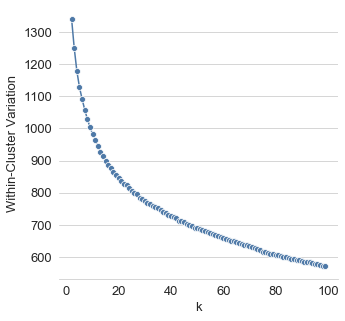

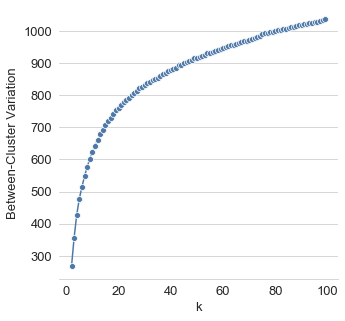

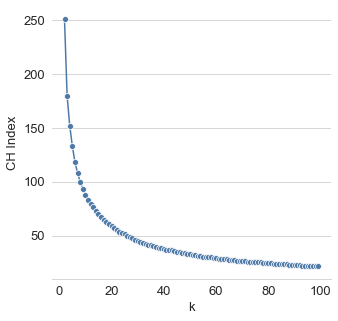

In [7]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_kmeans_after_dim_red.csv'))

plt.figure(figsize=[5,5])
sns.lineplot('k', 'WCSS', marker='o', data=results_df, color=blue_rgb)
plt.grid(axis='x')
plt.xlabel('k')
plt.ylabel('Within-Cluster Variation')
plt.savefig(os.path.join(output_path,'charts','ch_wcss_kmeans_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot('k', 'BCSS', marker='o', data=results_df, color=blue_rgb)
plt.grid(axis='x')
plt.xlabel('k')
plt.ylabel('Between-Cluster Variation')
plt.savefig(os.path.join(output_path,'charts','ch_bcss_kmeans_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot('k', 'CH_index', marker='o', data=results_df, color=blue_rgb)
plt.grid(axis='x')
plt.xlabel('k')
plt.ylabel('CH Index')
plt.savefig(os.path.join(output_path,'charts','report_ch_kmeans_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

We would choose k = 2 clusters since we get the max CH index for that value.

#### Average Silhouette Value

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values

# Initialize variables
results = []          
K_max = 100
K = range(2,K_max)
for k in tqdm(K):
    km = KMeans(n_clusters=k, n_init=100, n_jobs=-1, random_state=seed)
    cluster_labels = km.fit_predict(X)
    silhouette_avg_k = silhouette_score(X, cluster_labels)
    results.append([k,silhouette_avg_k])
results_df = pd.DataFrame(results,columns=['k','silhouette_avg'])
results_df.to_csv(os.path.join(output_path,'results','silhouette_kmeans_after_dim_red.csv'), index=None, header=True)

100%|██████████| 98/98 [04:58<00:00,  3.04s/it]


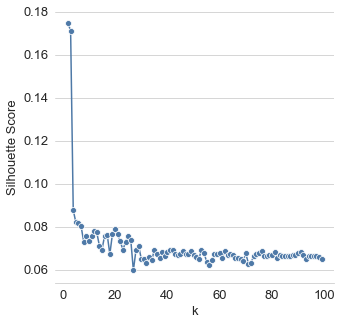

In [7]:
results_df = pd.read_csv(os.path.join(output_path,'results','silhouette_kmeans_after_dim_red.csv'))

plt.figure(figsize=(5,5))
sns.lineplot(x='k', y='silhouette_avg', marker='o', data=results_df, color=blue_rgb)
plt.grid(axis='x')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.savefig(os.path.join(output_path,'charts','report_silhouette_kmeans_after_dim_red.svg'), bbox_inches = 'tight')

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. Therefore, once again, 2 is the best number of clusters.

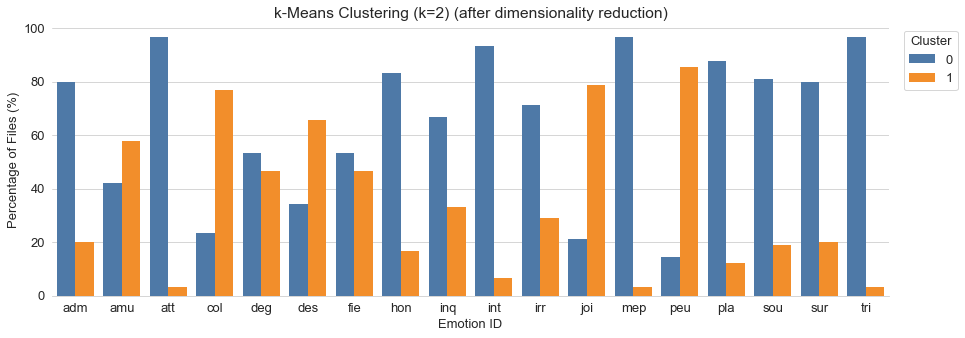

In [6]:
from sklearn.cluster import KMeans

X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values
km = KMeans(n_clusters=2, n_init=100, n_jobs=-1, random_state=seed)
labels = km.fit_predict(X)
tmp_df = multi_df.copy()

tmp_df['cluster'] = labels
tmp_df.head()
emotion_cluster = tmp_df.groupby(['emotion_id','cluster']).agg({'F0semitoneFrom27.5Hz_sma3nz_amean':'count'}).rename(columns={'F0semitoneFrom27.5Hz_sma3nz_amean':'counts'})
perc_df = emotion_cluster.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index().rename(columns={'counts':'percentage'})

plt.figure(figsize=[15,5])
sns.barplot(x='emotion_id', y='percentage', hue='cluster', data=perc_df, saturation=sns_saturation, palette=palette_def)
plt.xlabel('Emotion ID')
plt.ylabel('Percentage of Files (%)')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.09, 1))
plt.savefig(os.path.join(output_path,'charts','report_k_kmeans_k_2_after_dim_red.svg'), bbox_inches = 'tight')
plt.title('k-Means Clustering (k=2) (after dimensionality reduction)')
plt.savefig(os.path.join(output_path,'charts','k_kmeans_k_2_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

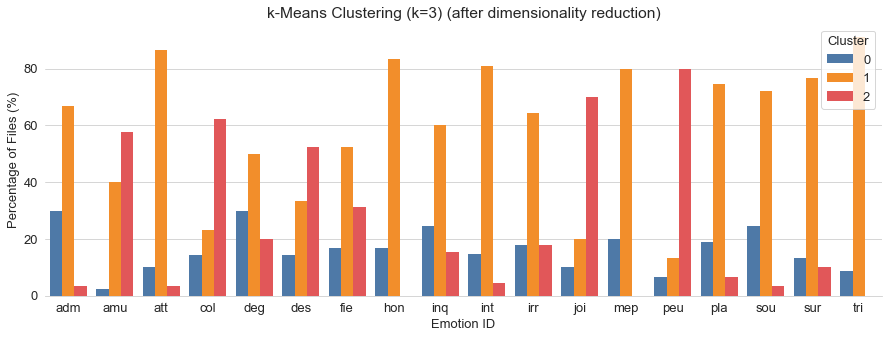

In [8]:
from sklearn.cluster import KMeans

X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values
km = KMeans(n_clusters=3, n_init=100, n_jobs=-1, random_state=seed)
labels = km.fit_predict(X)
tmp_df = multi_df.copy()

tmp_df['cluster'] = labels
tmp_df.head()
emotion_cluster = tmp_df.groupby(['emotion_id','cluster']).agg({'F0semitoneFrom27.5Hz_sma3nz_amean':'count'}).rename(columns={'F0semitoneFrom27.5Hz_sma3nz_amean':'counts'})
perc_df = emotion_cluster.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index().rename(columns={'counts':'percentage'})

plt.figure(figsize=[15,5])
sns.barplot(x='emotion_id', y='percentage', hue='cluster', data=perc_df, saturation=sns_saturation, palette=palette_def)
plt.xlabel('Emotion ID')
plt.ylabel('Percentage of Files (%)')
plt.legend(title='Cluster', loc='upper right')
plt.title('k-Means Clustering (k=3) (after dimensionality reduction)')
plt.savefig(os.path.join(output_path,'charts','k_kmeans_k_3_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

In [10]:
df_tmp = emotion_cluster.reset_index()
idx = df_tmp.groupby(['emotion_id'])['counts'].transform(max) == df_tmp['counts']
df_tmp[idx]

,emotion_id,cluster,counts
1,adm,1,20
5,amu,2,52
7,att,1,26
11,col,2,56
13,deg,1,15
17,des,2,47
19,fie,1,47
22,hon,1,25
24,inq,1,54
27,int,1,72


### Hierarchical Clustering

#### CH index

In [27]:
from scipy.cluster.hierarchy import linkage, cut_tree

def getCentroids(X,clusters,labels):
    X_tmp = X.copy()
    X_tmp['cluster'] = clusters    
    #centroids = {l: X_tmp.loc[X_tmp['cluster'] == l].mean().values for l in labels}
    centroids = [X_tmp.drop(columns='cluster').loc[X_tmp['cluster'] == l].mean().values for l in labels]
    return centroids

def calculateWCSS(X, clusters):
    labels, label_counts = np.unique(clusters, return_counts = True)
    X_tmp = X.copy()
    X_tmp['cluster'] = clusters
    centroids = getCentroids(X,clusters,labels)
    diff_cluster_sq = [np.linalg.norm(X_tmp.drop(columns='cluster').loc[X_tmp['cluster'] == l] - centroids[l])**2 for l in labels]
    return sum(diff_cluster_sq)

def calculateBCSS(X, clusters):
    labels, label_counts = np.unique(clusters, return_counts = True)
    diff_cluster_sq = np.linalg.norm(getCentroids(X,clusters,labels) - np.mean(X,axis=0).values, axis=1)**2
    return sum(label_counts * diff_cluster_sq)


X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values

K_max = 100
K = range(2,K_max)
method_values = ['single','complete','weighted']
results = []
for method in tqdm(method_values):
    links = linkage(X, method=method, metric='cityblock')
    
    for k in K:
        clusters = cut_tree(links, n_clusters=k)
        WCSS_k = calculateWCSS(X,clusters)
        BCSS_k = calculateBCSS(X,clusters)
        CH_k = (BCSS_k/WCSS_k)*((len(X)-k)/(k-1))
        results.append([method,
                        k,
                        WCSS_k,
                        BCSS_k,
                        CH_k]
                      )
results_df = pd.DataFrame(results,columns=['method','k','WCSS','BCSS','CH_index'])
results_df.to_csv(os.path.join(output_path,'results','ch_hier_clust_after_dim_red.csv'), index=None, header=True)

100%|██████████| 3/3 [10:17<00:00, 205.78s/it]


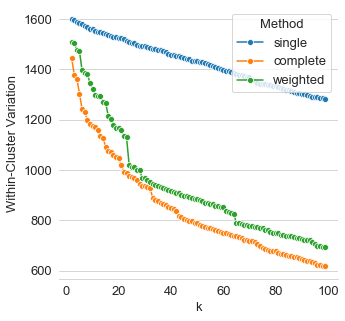

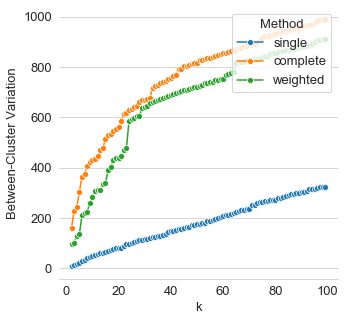

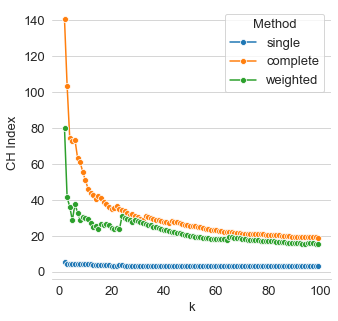

In [8]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_hier_clust_after_dim_red.csv'))

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='WCSS', marker='o', hue='method', data=results_df, color=palette_def)
plt.xlabel('k')
plt.ylabel('Within-Cluster Variation')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','ch_wcss_hier_clust_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='BCSS', marker='o', hue='method', data=results_df, color=palette_def)
plt.xlabel('k')
plt.ylabel('Between-Cluster Variation')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','ch_bcss_hier_clust_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='CH_index', marker='o', hue='method', data=results_df, color=palette_def)
plt.xlabel('k')
plt.ylabel('CH Index')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','report_ch_hier_clust_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

In [29]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_hier_clust_after_dim_red.csv'))
results_df.loc[results_df.groupby('method')['CH_index'].idxmax()]

,method,k,WCSS,BCSS,CH_index
98,complete,2,1444.780824,161.602519,140.598742
0,single,2,1599.311370,7.071974,5.558312
196,weighted,2,1510.411934,95.971409,79.869643


#### Average Silhouette Value

In [30]:
from scipy.cluster.hierarchy import linkage, cut_tree
from sklearn.metrics import silhouette_score


X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values


# Initialize variables
K_max = 100
K = range(2,K_max)
method_values = ['single','complete','weighted']
results = []
for method in tqdm(method_values):
    links = linkage(X, method=method, metric='cityblock')

    #for k in tqdm(K):
    for k in K:
        cluster_labels = cut_tree(links, n_clusters=k)
        silhouette_avg_k = silhouette_score(X, cluster_labels.ravel(), metric='cityblock')
        results.append([method,k,silhouette_avg_k])

results_df = pd.DataFrame(results, columns=['method', 'k', 'silhouette_avg'])
results_df.to_csv(os.path.join(output_path,'results','silhouette_hier_clust_after_dim_red.csv'), index=None, header=True)


100%|██████████| 3/3 [03:10<00:00, 63.59s/it] 


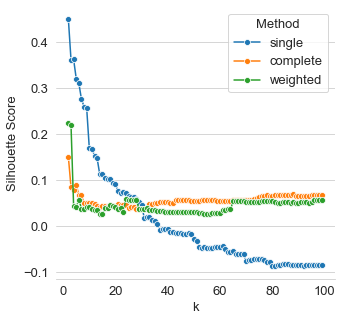

In [9]:
results_df = pd.read_csv(os.path.join(output_path,'results','silhouette_hier_clust_after_dim_red.csv'))
plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='silhouette_avg', marker='o', hue='method', data=results_df, color=palette_def)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','report_silhouette_hier_clust_after_dim_red.svg'), bbox_inches = 'tight')

In [32]:
results_df = pd.read_csv(os.path.join(output_path,'results','silhouette_hier_clust_after_dim_red.csv'))
results_df.loc[results_df.groupby('method')['silhouette_avg'].idxmax()]

,method,k,silhouette_avg
98,complete,2,0.149803
0,single,2,0.449545
196,weighted,2,0.225050


## Hierarchical clustering (after dimensionality reduction)

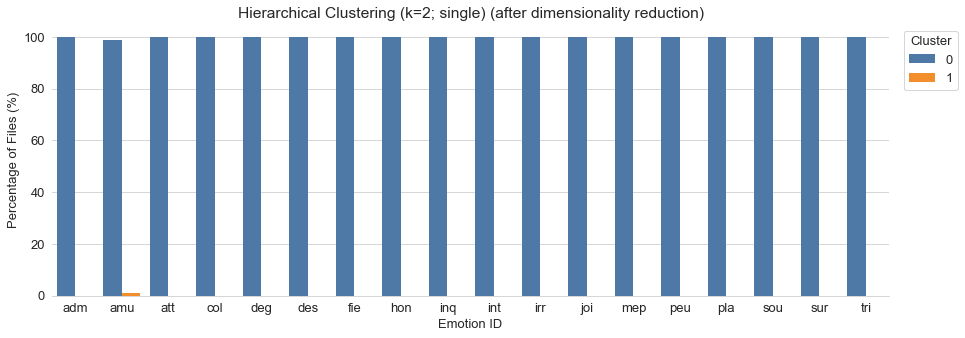

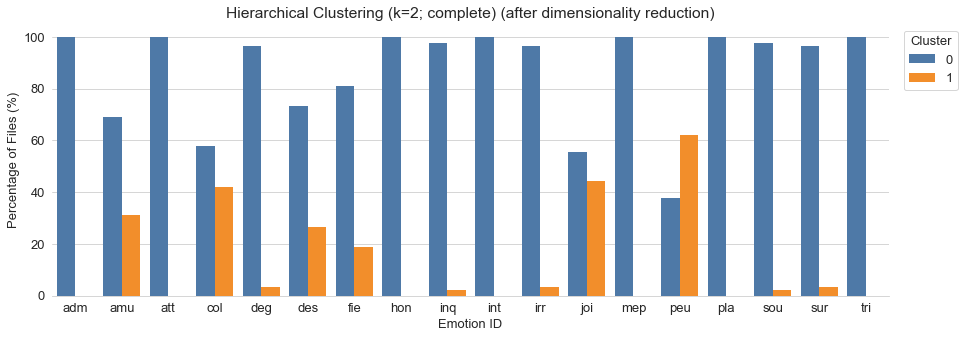

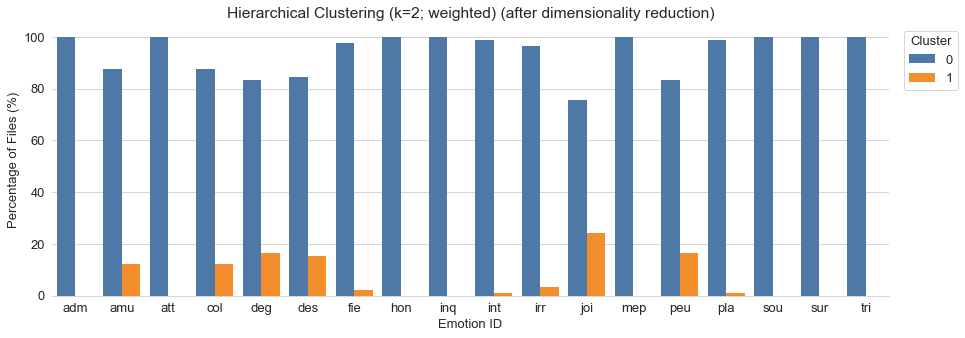

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
tmp_df = multi_df.copy()
X_df = multi_df.drop(columns=['emotion_id'])


n_clusters_values = [2]
distance_method = ['single', 'complete', 'weighted']

for method in distance_method:
    links = linkage(X_df, method=method, metric='cityblock')
    
    clusters = cut_tree(links, n_clusters=n_clusters_values)
    
        
    for n in range(0,len(n_clusters_values)):
        
        tmp_df['cluster_'+str(n_clusters_values[n])] = clusters[:,n]   
        emotion_cluster = tmp_df.groupby(['emotion_id','cluster_'+str(n_clusters_values[n])]).agg({'F0semitoneFrom27.5Hz_sma3nz_amean':'count'}).rename(columns={'F0semitoneFrom27.5Hz_sma3nz_amean':'counts'})
        perc_df = emotion_cluster.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index().rename(columns={'counts':'percentage'})
        
        plt.figure(figsize=(15, 5))
        sns.barplot(x='emotion_id', y='percentage', hue='cluster_'+str(n_clusters_values[n]), data=perc_df, saturation=sns_saturation, palette=palette_def)
        plt.xlabel('Emotion ID')
        plt.ylabel('Percentage of Files (%)')
        plt.legend(title='Cluster',loc=1, bbox_to_anchor=(1.09, 1))
        plt.savefig(os.path.join(output_path,'charts','report_hier_clust_k_'+str(n_clusters_values[n])+'_'+method+'_after_dim_red.svg'), bbox_inches = 'tight')
        plt.title('Hierarchical Clustering (k='+str(n_clusters_values[n])+'; '+method+') (after dimensionality reduction)')
        plt.savefig(os.path.join(output_path,'charts','hier_clust_k_'+str(n_clusters_values[n])+'_'+method+'_after_dim_red.svg'), bbox_inches = 'tight')